# Test di Pearson applicato ai dati di Centa San Nicolò

Matteo Franzoi - Andrea Rebellato - 2019-03-27

---

In [38]:
import os
from pandas import *
import pandas as pd
from numpy import *
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import math
from datetime import datetime
from scipy.stats import genextreme, gumbel_r
from numpy import linspace
from statsmodels.distributions.empirical_distribution import ECDF

In [39]:
pd.set_option('display.max_rows', 10)
data = read_csv('massimePrecipitazioniCenta.csv')
map(datetime, data['anno'])
data = data.set_index('anno')
data

,15min,30min,45min,1h,3h,6h,12h,24h
anno,,,,,,,,
1934,NaN,NaN,NaN,22.6,42.0,56.6,58.8,85.0
1935,NaN,NaN,NaN,17.8,32.6,54.2,63.6,88.0
1936,NaN,NaN,NaN,15.8,28.0,41.4,72.0,85.2
1937,NaN,NaN,NaN,27.8,35.6,38.2,58.4,62.6
1938,NaN,NaN,NaN,15.0,21.4,32.0,56.0,83.0
...,...,...,...,...,...,...,...,...
2000,23.2,33.0,34.8,36.4,42.2,52.8,90.0,120.4
2003,16.2,27.0,34.8,37.4,38.8,62.8,101.0,121.6
2004,25.8,37.4,40.2,42.2,43.0,45.2,57.6,80.4


In [40]:
os.getcwd()

'/media/data/jupyter/esercitazione'

In [41]:
os.listdir()

['.ipynb_checkpoints',
 'abs_ls',
 'abs_m',
 'abs_mle',
 'best_parameters',
 'lsCenta.ipynb',
 'lsppCenta.ipynb',
 'massimePrecipitazioniCenta.csv',
 'mleCenta.ipynb',
 'momentiCenta.ipynb',
 'pearsonCenta.ipynb']

['.ipynb_checkpoints',  
 'abs_ls',  
 'abs_m',  
 'abs_mle',  
 'best_parameters',  
 'lsCenta.ipynb',  
 'lsppCenta.ipynb',  
 **'massimePrecipitazioniCenta.csv'**,  
 'mleCenta.ipynb',  
 'momentiCenta.ipynb',  
 'pearsonCenta.ipynb']

Primo passaggio è leggere i file contenenti i valori di _a_ e *b* per ogni metodo

In [42]:
abs_m = read_pickle('abs_m')
abs_ls = read_pickle('abs_ls')
abs_mle = read_pickle('abs_mle')

In [43]:
abs_m

,15min,30min,45min,1h,3h,6h,12h,24h
a,11.511128,15.006803,17.491418,19.847805,29.813330,40.967347,56.917858,75.887001
b,4.257718,5.769142,6.619851,7.394091,10.262216,12.867616,21.080260,27.182547


In [44]:
abs_ls

,15min,30min,45min,1h,3h,6h,12h,24h
a,11.059733,14.647092,17.286796,19.448059,29.198662,40.251064,55.667629,74.324227
b,3.897447,5.400124,5.596108,6.838710,9.416240,13.179424,16.961686,23.546942


In [45]:
abs_mle

,15min,30min,45min,1h,3h,6h,12h,24h
a,11.551692,15.102191,17.638540,20.077738,30.042461,41.084931,57.402093,76.440792
b,4.051040,5.406040,6.168513,6.560461,9.253392,12.291069,19.296026,24.643281


Ricordando che _a_ è un parametro di localizzazione e *b* è un parametro di scala, si può mostrare il valore all'interno di un DataFrame anche con il comando `at`

Si crea la funzione `rv` che è definita come la funzione di gumbel che ha come input:
* loc: il parametro di localizzazione __a__;
* scale: il parametro di scala __b__.

Per la durata di 1h

In [46]:
rv = gumbel_r(loc = abs_m.at['a', '1h'], scale = abs_m.at['b', '1h'])

Ora, si suddivide l'asse delle ordinate in 5 intervalli uguali di valore $0.2$ l'uno

In [47]:
q = [.2, .4, .6, .8, 1]

attraverso la funzione `ppf` che calcola l'inversa della funzione probabilità, dai valori di __q__ sulle ordinate si calcola i valori dell'altezza di precipitazione **h** relativa alla curva di durata definita.  
Per la curva `rv` di 1h

In [48]:
h1h = rv.ppf(q)
h1h

array([16.3290678 , 20.49420758, 24.81461479, 30.93849669,         inf])

che sono i valori di precipitazione di probabilità di $0.2, 0.4, 0.6, 0.8, 1$ rispettivamente.  
La probabilità di 1 corrisponde a una altezza di precipitazione infinita.

Immagazziniamo il numero di dati della durata di 1h nella seguente variabile

In [49]:
l1h = len(data['1h'])
l1h

57

Si deve valutare la seguente funzione
$$
\large{X^2 = \sum_{j = 1}^{k} \dfrac{\left(N_j -n\left(P[H < h_{j+1}] - P[H < h_j]\right)\right)^2}{n\left(P[H < h_{j+1}] - P[H < h_j\right)}}
$$
dove
* $k$ è il numero di intervalli (in questo caso $5$);
* $N_j$ è il numero di dati presenti all'interno j-esimo intervallo;
* $n$ è il numero totale di dati;
* $P[H < h_{j+1}] - P[H < h_j]$ è semplicemente la dimensione dell'intervallo sull'asse delle ordinate (in questo caso $0.2$)

Inoltre, 
\begin{align*}
    P[H < h_0] &= P[H<0]\\
    P[H < h_{n+1}] &= P[H<\infty]
\end{align*}

Semplificando, essendo $k = 5$ e $P[H < h_{j+1}] - P[H < h_j] = 0.2$

$$
\large{X^2 = \dfrac{1}{0.2\,n}\,\sum_{j = 1}^5 \left(N_j - 0.2\,n\right)^2}
$$

Da qui, per ogni durata si deve scegliere le coppie di parametri __a__ e **b** che minimizzano $X^2$. I valori trovati saranno utilizzati per plottare le nuove curve di Gumbel ottimali.

Applicandolo ai dati, ci si aspetta che il numero di dati (di 1h) in un intervallo sia il prodotto tra il numero totale di dati di 1h e la dimensione dell'intervallo.
$$
e = l1h \cdot q %expected
$$

In realtà i dati non sono distribuiti omogeneamente e ogni intervallo può contenere un numero diverso di dati. Il numero di dati effettivamente presenti sono
$$
o = l1h \cdot r
$$
dove $r = ecdf1h(h1h)$ è il valore della _empirical cumulative distribution function_ calcolato per l'altezza di precipitazione di 1h, cioè

In [50]:
ecdf1h = ECDF(data['1h'])
r = ecdf1h(h1h)
r

array([0.21052632, 0.42105263, 0.59649123, 0.85964912, 1.        ])

In [51]:
o0 = l1h * r
o0

array([12., 24., 34., 49., 57.])

La funzione `np.delete(arr, obj, ...)` prende come input un array e ne elimina un elemento. Ad esempio per eliminare l'ultimo elemento del vettore __o0__

In [52]:
np.delete(o0, -1)

array([12., 24., 34., 49.])

Invece, la funzione `np.append(arr, values, ...)` aggiunge un valore all'array

In [53]:
np.append(o0, 1)

array([12., 24., 34., 49., 57.,  1.])

Quello che si vuole fare è creare il vettore __o__ che modifica il vettore **o0**. In particolare al vettore **o0** viene tolto il seguente vettore

In [54]:
np.append([0], np.delete(o0, -1))

array([ 0., 12., 24., 34., 49.])

che consiste in un vettore dove all'elemento $0$ viene aggiunto il vettore __o0__ dove è stato eliminato l'ultimo elemento.  
Il vettore **o** diventa

In [55]:
o = o0 - np.append([0], np.delete(o0, -1))
o #observed

array([12., 12., 10., 15.,  8.])

Il numero di valori che ci si aspetta per ogni intervallo sono

In [56]:
e = [0.2 * l1h for i in range(len(r))]
e

[11.4, 11.4, 11.4, 11.4, 11.4]

distribuiti in modo omogeneo.

La differenza tra i valori osservati e quelli che ci si aspettava è

In [57]:
o-e

array([ 0.6,  0.6, -1.4,  3.6, -3.4])

e il suo quadrato vale

In [58]:
(o-e)**2

array([ 0.36,  0.36,  1.96, 12.96, 11.56])

e dividendo per $e = 0.2 \cdot n$ si ottiene

In [59]:
(o-e)**2/e

array([0.03157895, 0.03157895, 0.17192982, 1.13684211, 1.01403509])

Infine, sommando ogni intervallo 

In [60]:
((o-e)**2/e).sum()

2.385964912280696

che corrisponde al valore di $X^2$ per la __durata di 1h__.

$$
\Large X^2 = 2.385964912280696
$$

Il procedimento può essere automatizzato per ogni durata definendo la seguente funzione

In [61]:
def X2(data, abs_t, h, delta):
    dt = data[h].dropna()
    lh = len(dt)
    q = [delta*(i+1) for i in range(0, int(1/delta))]
    rv = gumbel_r(loc = abs_t.at['a', h], scale = abs_t.at['b', h])
    ecdf = ECDF(dt)
    #r=ecdf(h1h), h1h=rv.ppf(q)
    r = ecdf(rv.ppf(q))
    o0 = lh * r
    o = o0 - np.append([0], np.delete(o0, -1))
    e = [delta * lh for i in range(len(r))]
    return ((o-e)**2/e).sum()

Applicandolo ai dati di 1h per il __metodo dei momenti__

In [62]:
X2(data, abs_m, '1h', 0.2)

2.385964912280696

Per 3h

In [63]:
X2(data, abs_m, '3h', 0.2)

1.3333333333333333

Per 6h

In [64]:
X2(data, abs_m, '6h', 0.2)

1.3333333333333284

Per 12h

In [65]:
X2(data, abs_m, '12h', 0.2)

3.9999999999999947

Per 24h

In [66]:
X2(data, abs_m, '24h', 0.2)

2.9122807017543857

Applicandolo a tutti i metodi e stampandoli a schermo

In [67]:
print('\t\tm\t\tls\t\tmle\n')
for h in data.columns:
    print(h, ':', X2(data, abs_m, h, .2), X2(data, abs_ls, h, .2), X2(data, abs_mle, h, .2))

		m		ls		mle

15min : 0.8124999999999999 1.75 0.8124999999999999
30min : 0.15789473684210503 0.6842105263157892 0.15789473684210503
45min : 0.8125 0.8125 0.8125
1h : 2.385964912280696 3.43859649122807 1.3333333333333284
3h : 1.3333333333333333 1.1578947368421004 0.8070175438596479
6h : 1.3333333333333284 0.9824561403508723 2.0350877192982404
12h : 3.9999999999999947 4.535714285714286 5.964285714285708
24h : 2.9122807017543857 2.56140350877193 1.5087719298245614


Si devono scegliere i valori più bassi per ogni durata e si costruisce, attraverso un ciclo _for_, un DataFrame.  
Si inizializza un vettore *a* nullo e, per ogni _h_ viene aggiornato il vettore *a* e immagazzinato nel DataFrame

In [68]:
a = []
#------------------------------------------
for h in data.columns:
    a = a + [[X2(data, abs_m, h, .2), X2(data, abs_ls, h, .2), X2(data, abs_mle, h, .2)]]
pd.DataFrame(a, index = ['15min', '30min', '45min','1h', '3h', '6h', '12h', '24h'], columns = ['M', 'LS', 'MLE'])


,M,LS,MLE
15min,0.812500,1.750000,0.812500
30min,0.157895,0.684211,0.157895
45min,0.812500,0.812500,0.812500
1h,2.385965,3.438596,1.333333
3h,1.333333,1.157895,0.807018
6h,1.333333,0.982456,2.035088
12h,4.000000,4.535714,5.964286
24h,2.912281,2.561404,1.508772


I valori più bassi vengono salvati nel DataFrame _best_

In [69]:
best=DataFrame([abs_m["15min"],
                abs_mle["30min"],
                abs_ls["45min"],
                abs_mle["1h"],
                abs_mle["3h"],
                abs_ls["6h"],
                abs_m["12h"],
                abs_mle["24h"]]).T
                  
best

,15min,30min,45min,1h,3h,6h,12h,24h
a,11.511128,15.102191,17.286796,20.077738,30.042461,40.251064,56.917858,76.440792
b,4.257718,5.406040,5.596108,6.560461,9.253392,13.179424,21.080260,24.643281


Che viene salvano nel file `best_parameters`

In [70]:
best.to_pickle('best_parameters')

In [71]:
os.listdir()

['.ipynb_checkpoints',
 'abs_ls',
 'abs_m',
 'abs_mle',
 'best_parameters',
 'lsCenta.ipynb',
 'lsppCenta.ipynb',
 'massimePrecipitazioniCenta.csv',
 'mleCenta.ipynb',
 'momentiCenta.ipynb',
 'pearsonCenta.ipynb']

['.ipynb_checkpoints',  
 'abs_ls',  
 'abs_m',  
 'abs_mle',  
 '**best_parameters**',  
 'lsCenta.ipynb',  
 'massimePrecipitazioniCenta.csv',  
 'mleCenta.ipynb',  
 'momentiCenta.ipynb',  
 'pearsonCenta.ipynb']


## Plot

Si può procedere al plot delle curve di Gumbel definite con i migliori parametri.  
Per prima cosa si deve definire la funzione di Gumbel nonché il solito vettore **t_rain** compreso tra i valori minimo e massimo di _data_

In [72]:
def gumbel(x, abs_d, col):
    return np.exp(- np.exp(-(x - abs_d[col]['a'])/abs_d[col]['b']))
#--------------------------------------------------------------
t_rain = np.linspace(data.min()['15min'], data.max()['24h'], 100)

In [73]:
teta = []
for h in data.columns:
    teta = teta + [gumbel(t_rain, best, h)]
    
#-------------------------------------------
gb = pd.DataFrame(teta, index = ['15min', '30min', '45min','1h', '3h', '6h', '12h', '24h'], columns = t_rain).T

#-------------------------------------------
gb

,15min,30min,45min,1h,3h,6h,12h,24h
5.200000,0.012241,0.001941,0.000172,0.000064,4.325293e-07,6.224760e-07,0.000009,1.509098e-08
7.086869,0.059207,0.012220,0.002053,0.000714,6.455776e-06,4.187288e-06,0.000024,5.691406e-08
8.973737,0.162878,0.044739,0.012068,0.004368,5.852369e-05,2.184341e-05,0.000060,1.946382e-07
10.860606,0.311899,0.111745,0.042727,0.016987,3.532736e-04,9.141441e-05,0.000138,6.079599e-07
12.747475,0.473321,0.213131,0.105345,0.047042,1.530609e-03,3.160678e-04,0.000295,1.746070e-06
...,...,...,...,...,...,...,...,...
184.452525,1.000000,1.000000,1.000000,1.000000,9.999999e-01,9.999823e-01,0.997645,9.875899e-01
186.339394,1.000000,1.000000,1.000000,1.000000,1.000000e+00,9.999847e-01,0.997846,9.884994e-01
188.226263,1.000000,1.000000,1.000000,1.000000,1.000000e+00,9.999867e-01,0.998030,9.893426e-01
190.113131,1.000000,1.000000,1.000000,1.000000,1.000000e+00,9.999885e-01,0.998199,9.901242e-01


### Plot

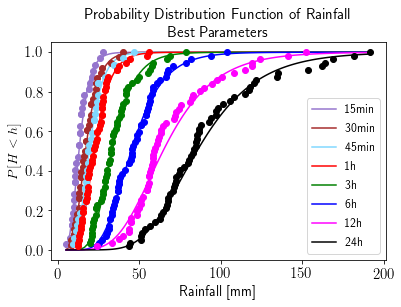

In [74]:
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

#----------------plot---------------

ax = gb.plot(color = ['#9575cd', 'brown', '#80d8ff','red', 'green', 'blue', 'magenta', 'black'])
#plt.figure(figsize = (18 ,16), dpi = 100)

#--------------15min--------------------
data15min = data['15min'].dropna()
ecdf15min = ECDF(data15min)
ax.plot(data15min, ecdf15min(data15min), 'o', c = '#9575cd')

#--------------30min--------------------
data30min = data['30min'].dropna()
ecdf30min = ECDF(data30min)
ax.plot(data30min, ecdf30min(data30min), 'o', c = 'brown')

#--------------45min--------------------
data45min = data['45min'].dropna()
ecdf45min = ECDF(data45min)
ax.plot(data45min, ecdf45min(data45min), 'o', c = '#80d8ff')

#--------------1h--------------------
data1h = data['1h'].dropna()
ecdf1h = ECDF(data1h)
ax.plot(data1h, ecdf1h(data1h), 'o', c = 'red')

#--------------3h--------------------
data3h = data['3h'].dropna()
ecdf3h = ECDF(data3h)
ax.plot(data3h, ecdf3h(data3h), 'o', c = 'green')

#--------------6h--------------------
data6h = data['6h'].dropna()
ecdf6h = ECDF(data6h)
ax.plot(data6h, ecdf6h(data6h), 'o', c = 'blue')

#--------------12h-------------------
data12h = data['12h'].dropna()
ecdf12h = ECDF(data12h)
ax.plot(data12h, ecdf12h(data12h), 'o', c = 'magenta')

#--------------24h-------------------
data24h = data['24h'].dropna()
ecdf24h = ECDF(data24h)
ax.plot(data24h, ecdf24h(data24h), 'o', c = 'black')


#--------------------label-----------
ax.set_title('Probability Distribution Function of Rainfall\nBest Parameters', fontsize = 15)
ax.set_xlabel('Rainfall [mm]',fontsize = 14)
ax.set_ylabel(r'$P[H < h]$', fontsize = 14)
ax.legend(loc = 4, fontsize = 12)

#------------------------------------
plt.show()